# Verification of Elastic wave equation implementation on a staggered grid using the method of manufactured solutions.
This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (201, 201)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

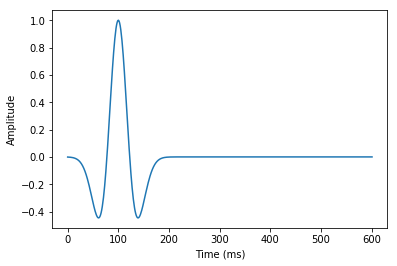

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 600.
dt = (10. / np.sqrt(2.)) / 6.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
#from examples.seismic import Model
# Model with fixed time step value
#class ModelBench(Model):
#    """
#    Physical model used for accuracy benchmarking.
#    The critical dt is made small enough to ignore
#    time discretization errors
#    """
#
#    @property
#    def critical_dt(self):
#        """Critical computational time step value."""
#        return .1*self.spacing[0]

In [5]:
# Now we create the velocity and pressure fields


#model = ModelBench(vp=1.5, origin=(0., 0.), spacing=(.5, .5), shape=(801, 801), nbpml=40, space_order=0, dtype=np.float64)

so = 2 # space order
vx  = TimeFunction(name='vx' , grid=grid, staggered = x,    space_order=so)
vz  = TimeFunction(name='vz' , grid=grid, staggered = z,    space_order=so)
txx = TimeFunction(name='txx', grid=grid, staggered = NODE, space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered = NODE, space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so)

In [6]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3.

# The source injection term
src_xx = src.inject(field=txx.forward, expr=src)
src_zz = src.inject(field=tzz.forward, expr=src)

#c1 = 9.0/8.0;
#c2 = -1.0/24.0;

# Thorbecke's parameter notation
cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1/density

mu = cs2*ro
l = (cp2*ro - 2*mu)

print(x,z,time)


x z time


# Analytical solution definition

In [7]:
# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

#op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

#op()



In [8]:
# Let's see what we got....
#plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
#plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

Operator `Kernel` run in 1.08 s


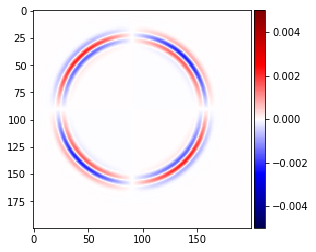

In [9]:
# Now that looks pretty! But let's do it again with a higher space order...
so  = 12
vx  = TimeFunction(name='vx' , grid=grid, staggered=x     , space_order=so, time_order=2)
vz  = TimeFunction(name='vz' , grid=grid, staggered=z     , space_order=so, time_order=2)
txx = TimeFunction(name='txx', grid=grid, staggered=NODE  , space_order=so, time_order=2)
tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE  , space_order=so, time_order=2)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so, time_order=2)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))
u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))
u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)
u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op()

vmin= -.5*1e-2
vmax=  .5*1e-2

#plot_image(vx.data[0] , vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(vz.data[0] , vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(txx.data[0], vmin = vmin, vmax = vmax, cmap="seismic")
#plot_image(tzz.data[0], vmin = vmin, vmax = vmax, cmap="seismic")
plot_image(txz.data[0], vmin = vmin, vmax = vmax, cmap="seismic")

# Corresponding source

In [10]:
import sympy
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc
u, v, w = sympy.symbols('x z time')
sol = sin(2*np.pi*x) * sin(4*np.pi*z)* sin(2*np.pi*time)
#sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)
#sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)
#sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)
#sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)

source =  sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
source = source.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})

print(sol)

sin(6.28318530717959*x*h_x)*sin(12.5663706143592*z*h_z)*sin(6.28318530717959*time*dt)


# Elastic wave equation

In [11]:

so = 2
vx_ana  = TimeFunction(name='vx_ana',  grid=grid, staggered=x,      space_order=so, time_order=2)
vz_ana  = TimeFunction(name='vz_ana',  grid=grid, staggered=z,      space_order=so, time_order=2)
txx_ana = TimeFunction(name='txx_ana', grid=grid, staggered=NODE,   space_order=so, time_order=2)
tzz_ana = TimeFunction(name='tzz_ana', grid=grid, staggered=NODE,   space_order=so, time_order=2)
txz_ana = TimeFunction(name='txz_ana', grid=grid, staggered=(x, z), space_order=so, time_order=2)
    
# Wave equation
u_vx_true  = TimeFunction(name='u_vx_true' , grid=grid, staggered=x,      space_order=so, time_order=2)
u_vz_true  = TimeFunction(name='u_vz_true' , grid=grid, staggered=z,      space_order=so, time_order=2)
u_txx_true = TimeFunction(name='u_txx_true', grid=grid, staggered=NODE,   space_order=so, time_order=2)
u_tzz_true = TimeFunction(name='u_tzz_true', grid=grid, staggered=NODE,   space_order=so, time_order=2)
u_txz_true = TimeFunction(name='u_txz_true', grid=grid, staggered=(x, z), space_order=so, time_order=2)
    
#vx_src  = TimeFunction(name="vx_src" , grid=grid, staggered=x,     space_order=so, time_order=2)
#vz_src  = TimeFunction(name='vz_src' , grid=grid, staggered=z,      space_order=so, time_order=2)
#txx_src = TimeFunction(name='txx_src', grid=grid, staggered=NODE,   space_order=so, time_order=2)
#tzz_src = TimeFunction(name='tzz_src', grid=grid, staggered=NODE,   space_order=so, time_order=2)
#txz_src = TimeFunction(name='txz_src', grid=grid, staggered=(x, z), space_order=so, time_order=2)
    
#wave_eq = Eq(vx.forward, 2 * vx - vx.backward + t.spacing**2/1 * (vx.laplace + src))
    
print(vx_ana)
print(u_vx_true)
#print(vx_src)
    
    
    

vx_ana(t, x, z)
u_vx_true(t, x, z)


In [12]:
# Adding analytical source
# fdelmodc reference implementation
src_vx  = sol.diff(vx_ana, time) - ro * sol.diff(txx_ana,x) - ro * sol.diff(txz_ana,z)
src_vz  = sol.diff(vz_ana, time) - ro * sol.diff(txz_ana,x) + ro * sol.diff(tzz_ana,z)
src_txx = sol.diff(txx_ana,time) - (l+2*mu) * sol.diff(vx_ana.forward,x) -  l* sol.diff(vz_ana.forward,z)
src_tzz = sol.diff(tzz_ana,time) - (l+2*mu) * sol.diff(vz_ana.forward,z) -  l* sol.diff(vx_ana.forward,x)
src_txz = sol.diff(txz_ana,time) - mu*(sol.diff(vx_ana.forward,z) + sol.diff(vz_ana.forward,x))

 
src_vx  = src_vx.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
src_vz  = src_vz.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
src_txx = src_txx.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
src_txz = src_txz.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
src_tzz = src_tzz.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})

wave_u_vx  = Eq(vx.forward,  vx - dt*ro*(txx.dx + txz.dz+src_vx))
wave_u_vz  = Eq(vz.forward,  vz - dt*ro*(txz.dx + tzz.dz+src_vz))
wave_u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz + src_txx)
wave_u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx+src_tzz)
wave_u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx)+src_txz)
    
# +src?
print(src_vx)
print(wave_u_vx)

0
Eq(vx(t + dt, x, z), vx(t, x, z) + 0.479786236456494*txz(t, x, z)/h_z - 8.58263096987177e-6*txz(t, x, z - 5*h_z)/h_z + 0.00014103063974801*txz(t, x, z - 4*h_z)/h_z - 0.00116566141016759*txz(t, x, z - 3*h_z)/h_z + 0.00685408909252146*txz(t, x, z - 2*h_z)/h_z - 0.0380782727346424*txz(t, x, z - h_z)/h_z - 0.479786236456494*txz(t, x, z + h_z)/h_z + 0.0380782727346424*txz(t, x, z + 2*h_z)/h_z - 0.00685408909252146*txz(t, x, z + 3*h_z)/h_z + 0.00116566141016759*txz(t, x, z + 4*h_z)/h_z - 0.00014103063974801*txz(t, x, z + 5*h_z)/h_z + 8.58263096987177e-6*txz(t, x, z + 6*h_z)/h_z - 0.479786236456494*txx(t, x, z)/h_x - 8.58263096987177e-6*txx(t, x - 6*h_x, z)/h_x + 0.00014103063974801*txx(t, x - 5*h_x, z)/h_x - 0.00116566141016759*txx(t, x - 4*h_x, z)/h_x + 0.00685408909252146*txx(t, x - 3*h_x, z)/h_x - 0.0380782727346424*txx(t, x - 2*h_x, z)/h_x + 0.479786236456494*txx(t, x - h_x, z)/h_x + 0.0380782727346424*txx(t, x + h_x, z)/h_x - 0.00685408909252146*txx(t, x + 2*h_x, z)/h_x + 0.0011656614

In [13]:
true_eqq_vx  = Eq(u_vx_true, sol)
true_eqq_vz  = Eq(u_vz_true, sol)
true_eqq_txx = Eq(u_txx_true, sol)
true_eqq_txz = Eq(u_txz_true, sol)
true_eqq_tzz = Eq(u_tzz_true, sol)
print(true_eqq_vx)

Eq(u_vx_true(t, x, z), sin(6.28318530717959*x*h_x)*sin(12.5663706143592*z*h_z)*sin(6.28318530717959*time*dt))


In [14]:
#src_eq_vx  = Eq(vx_ana.forward, vx_ana.dt-  ro * txx_ana.dx -ro * txz_ana.dz) 
#src_eq_vz  = Eq(vz_ana.forward, vz_ana.dt - ro * (txz_ana.dx + tzz_ana.dz))
#src_eq_txx = Eq(txx_ana.forward, txx_ana.dt - (l+2*mu)*dt * vx_ana.forward.dx -  l*dt * vz_ana.forward.dz)
#src_eq_txz = Eq(txz_ana.forward, tzz_ana - (l+2*mu)*dt * vz_ana.forward.dz -  l*dt * vx_ana.forward.dx)
#src_eq_tzz = Eq(tzz_ana.forward, tzz_ana - mu*dt * (vx_ana.forward.dz + vz_ana.forward.dx))
#wave_u_txz = Eq(txz.forward, txz_ana - mu*dt * (vx_ana.forward.dz + vz_ana.forward.dx))

#print(src_eq_vx)

In [15]:
# inital conditions, t=1
print(vx_ana)
u_1 = Eq(vx_ana.subs(time, 1), sol.subs(time, 1))
#u_1 = Eq(vx_ana.subs(time, 1))

print(u_1)

vx_ana(t, x, z)
Eq(vx_ana(t, x, z), sin(6.28318530717959*dt)*sin(6.28318530717959*x*h_x)*sin(12.5663706143592*z*h_z))


In [16]:
## from devito import configuration
configuration["log-level"] = "ERROR"
h = .00125
op = Operator([u_1,true_eqq_vx,wave_u_vx], subs=({time.spacing: .1*h, x.spacing:h, z.spacing:h}))
op.apply(t_m=1, t_M=100)

PerformanceSummary([('section0',
  PerfEntry(time=0.11418400000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [21]:
import sympy
from sympy import cos, sin, exp, pprint, sqrt, sin, sinc

def get_solution_elastic(size, space_order):
    clear_cache()
    
    # Grid
    h = 1./(size - 1)
    dt = 1e-7
    #nt = 86
    # Initial grid: 1km x 1km, with spacing 100m
    extent = (2000., 2000.)
    shape = (size, size)
    x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
    z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
    grid = Grid(extent=extent, shape=shape, dimensions=(x, z))
    
    #x, z = grid.dimensions
    t = grid.stepping_dim
    time = grid.time_dim
    #print(x,z,time)
    # Model
    # Timestep size from Eq. 7 with V_p=6000. and dx=100
    t0, tn = 0., 600.
    #dt = (10. / np.sqrt(2.)) / 6000.

    #time_range = TimeAxis(start=t0, stop=tn, step=dt)
    #src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
    #src.coordinates.data[:] = [1000., 1000.]
    
    nt = 101;   # FIX ME
    
    # Now we create the velocity and pressure fields
    so = space_order
    
    vx  = TimeFunction(name='vx' , grid=grid, staggered = x,    space_order=so, time_order=2, save=nt)
    vz  = TimeFunction(name='vz' , grid=grid, staggered = z,    space_order=so, time_order=2, save=nt)
    txx = TimeFunction(name='txx', grid=grid, staggered = NODE, space_order=so, time_order=2, save=nt)
    tzz = TimeFunction(name='tzz', grid=grid, staggered = NODE, space_order=so, time_order=2, save=nt)
    txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so, time_order=2, save=nt)

    vx_ana  = TimeFunction(name='vx_ana',  grid=grid, staggered=x,      space_order=so, time_order=2, save=nt)
    vz_ana  = TimeFunction(name='vz_ana',  grid=grid, staggered=z,      space_order=so, time_order=2, save=nt)
    txx_ana = TimeFunction(name='txx_ana', grid=grid, staggered=NODE,   space_order=so, time_order=2, save=nt)
    tzz_ana = TimeFunction(name='tzz_ana', grid=grid, staggered=NODE,   space_order=so, time_order=2, save=nt)
    txz_ana = TimeFunction(name='txz_ana', grid=grid, staggered=(x, z), space_order=so, time_order=2, save=nt)
    
    # Wave equation
    #u_vx_true  = TimeFunction(name='u_vx_true' , grid=grid, staggered=x,      space_order=so, time_order=0, save=nt)
    #u_vz_true  = TimeFunction(name='u_vz_true' , grid=grid, staggered=z,      space_order=so, time_order=0, save=nt)
    #u_txx_true = TimeFunction(name='u_txx_true', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    #u_tzz_true = TimeFunction(name='u_tzz_true', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    #u_txz_true = TimeFunction(name='u_txz_true', grid=grid, staggered=(x, z), space_order=so, time_order=0, save=nt)
    
    #vx_src  = TimeFunction(name="vx_src" , grid=grid, staggered=x,     space_order=so, time_order=0, save=nt)
    #vz_src  = TimeFunction(name='vz_src' , grid=grid, staggered=z,      space_order=so, time_order=0, save=nt)
    #txx_src = TimeFunction(name='txx_src', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    #tzz_src = TimeFunction(name='tzz_src', grid=grid, staggered=NODE,   space_order=so, time_order=0, save=nt)
    #txz_src = TimeFunction(name='txz_src', grid=grid, staggered=(x, z), space_order=so, time_order=0, save=nt)


    
    ###################input = ###########################################################
    u, v, w = sympy.symbols('x z time')
    #sol = 1*sin(2*np.pi*u) * sin(4*np.pi*v)* sin(6*np.pi*w)* sin(8*np.pi*u)
    sol = (1e4*sin(6*np.pi*x) * exp(-(z - .50)**2/.0150 - (time-.50)**2/.0150) -
           1e3*sin(4*np.pi*x) * exp(-(z - .45)**2/.0025 - (time-.65)**2/.0025) -
           5e3*sin(8*np.pi*x) * exp(-(z - .65)**2/.0025 - (time-.45)**2/.0015) +
           1e4*sin(6*np.pi*x) * exp(-(z - .45)**2/.0015 - (time-.45)**2/.0025) -
           5e3*sin(6*np.pi*x) * exp(-(z - .65)**2/.0027 - (time-.65)**2/.0021) )
    
    #sol = (1*sin(6*np.pi*w) * exp(-(u - .5)**2/.015 - (v-.5)**2/.015) -
    #    1*sin(4*np.pi*w) *exp(-(u - .45)**2/.0025 - (v-.65)**2/.0025)-
    #    5*sin(8*np.pi*w) *exp(-(u - .65)**2/.0025 - (v-.45)**2/.0015)+
    #    1*sin(6*np.pi*w) * exp(-(u - .45)**2/.0015 - (v-.45)**2/.0025)-
    #    5*sin(6*np.pi*w) * exp(-(u - .65)**2/.0027 - (v-.65)**2/.0021))
    
    #source_vx  =  sol.diff(vz, vz) - sol.diff(txx, txx) - sol.diff(vx, vx)
    #source_vz  =  sol.diff(vx, vx) - sol.diff(vz, vz) - sol.diff(txx, tzz)
    #source_txx =  sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    #source_tzz =  sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    #source_txz =  sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    
    #x, z = grid.dimensions
    #t = grid.time_dim
    
    #print(sol)
    #sol       = sol.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    #print(sol)
    #source_vx = source_vx.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    #source_vz = source_vz.subs({u: x*x.spacing, v: z*z.spacing, w: t*t.spacing, c: sqrt(1/model.m)})
    #################################################################################
    
    #u, v, w, c = sympy.symbols('u v w c')
    #sol = sin(2*np.pi*u) * sin(4*np.pi*v)* sin(2*np.pi*w)

    #source =  sol.diff(w, w) - sol.diff(u, u) - sol.diff(v, v)
    sol = sol.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
    #source = source.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
    
    #print(sol)
    #print(source)

    
    # fdelmodc reference implementation
    src_vx  = sol.diff(vx_ana, time) - ro * sol.diff(txx_ana,x) - ro * sol.diff(txz_ana,z)
    src_vz  = sol.diff(vz_ana, time) - ro * sol.diff(txz_ana,x) + ro * sol.diff(tzz_ana,z)
    src_txx = sol.diff(txx_ana,time) - (l+2*mu) * sol.diff(vx_ana.forward,x) -  l* sol.diff(vz_ana.forward,z)
    src_tzz = sol.diff(tzz_ana,time) - (l+2*mu) * sol.diff(vz_ana.forward,z) -  l* sol.diff(vx_ana.forward,x)
    src_txz = sol.diff(txz_ana,time) - mu*(sol.diff(vx_ana.forward,z) + sol.diff(vz_ana.forward,x))

    
    src_vx  = src_vx.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
    src_vz  = src_vz.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
    src_txx = src_txx.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
    src_txz = src_txz.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})
    src_tzz = src_tzz.subs({u: x*x.spacing, v: z*z.spacing, w: time*time.spacing})

    
    
    
    

    wave_u_vx  = Eq(vx.forward,  vx - dt*ro*(txx.dx + txz.dz ) + src_vx)
    wave_u_vz  = Eq(vz.forward,  vz - dt*ro*(txz.dx + tzz.dz ) + src_vz)
    wave_u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz + src_txx)
    wave_u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx + src_tzz)
    wave_u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx) + src_txz)
    
    
    
    # fdelmodc reference implementation
    #wave_u_vx  = Eq(vx_ana.forward, vx_ana - ro*(txx_ana.dx + txz_ana.dz))
    #wave_u_vz  = Eq(vz_ana.forward, vz_ana - ro*dt*(txz_ana.dx + tzz_ana.dz))
    #wave_u_txx = Eq(txx_ana.forward, txx_ana - (l+2*mu)*dt * vx_ana.forward.dx -  l*dt * vz_ana.forward.dz)
    #wave_u_tzz = Eq(tzz_ana.forward, tzz_ana - (l+2*mu)*dt * vz_ana.forward.dz -  l*dt * vx_ana.forward.dx)
    #wave_u_txz = Eq(txz_ana.forward, txz_ana - mu*dt * (vx_ana.forward.dz + vz_ana.forward.dx))
    
    true_eqq_vx = Eq(vx_ana, sol)
    true_eqq_vz = Eq(vz_ana, sol)
    true_eqq_txx = Eq(txx_ana, sol)
    true_eqq_txz = Eq(txz_ana, sol)
    true_eqq_tzz = Eq(tzz_ana, sol)
    
    #src_eq_vx  = Eq(vx_ana.forward, vx_ana.dt - dt*ro * txx_ana.dx -ro *dt* txz_ana.dz) 
    #src_eq_vz  = Eq(vz_ana.forward, vz_ana.dt - dt*ro * (txz_ana.dx + tzz_ana.dz))
    #src_eq_txx = Eq(txx_ana.forward, txx_ana.dt - (l+2*mu)*dt * vx_ana.forward.dx -  l*dt * vz_ana.forward.dz)
    #src_eq_txz = Eq(txz_ana.forward, tzz_ana.dt - (l+2*mu)*dt * vz_ana.forward.dz -  l*dt * vx_ana.forward.dx)
    #src_eq_tzz = Eq(tzz_ana.forward, tzz_ana.dt - mu*dt * (vx_ana.forward.dz + vz_ana.forward.dx))
    
    u_1 = Eq(vx_ana.subs(time, 1), sol.subs(time, 1))
    u_2 = Eq(vz_ana.subs(time, 1), sol.subs(time, 1))
    u_3 = Eq(txx_ana.subs(time, 1), sol.subs(time, 1))
    u_4 = Eq(txz_ana.subs(time, 1), sol.subs(time, 1))
    u_5 = Eq(tzz_ana.subs(time, 1), sol.subs(time, 1))

    configuration["log-level"] = "ERROR"
    
    
    #op = Operator([u_1,u_2,u_3,u_4,u_5,true_eqq_vx,true_eqq_vz,true_eqq_txx,true_eqq_txz,true_eqq_tzz,src_eq_vx,wave_u_vx], subs=({time.spacing: .1*h, x.spacing:h, z.spacing:h}))
    #op = Operator([u_1,wave_u_vx], subs=({time.spacing: .1*h, x.spacing:h, z.spacing:h}))
    #op = Operator([u_1,u_2,u_3,u_4,u_5,true_eqq_vx,true_eqq_vz,true_eqq_txx,true_eqq_txz,true_eqq_tzz, wave_u_vx,wave_u_vz], subs=({time.spacing: .1*h, x.spacing:h, z.spacing:h}))
    op = Operator([u_1,u_2,u_3,u_4,u_5,true_eqq_vx,true_eqq_vz,true_eqq_txx,true_eqq_txz,true_eqq_tzz, wave_u_vx,wave_u_vz,wave_u_txx,wave_u_txz,wave_u_tzz], subs=({time.spacing: .1*h, x.spacing:h, z.spacing:h}))

    op.apply()
    
    # Reset the fields
    #vx_ana.data[:] = 0.
    #vz_ana.data[:] = 0.
    #txx_ana.data[:] = 0.
    #tzz_ana.data[:] = 0.
    #txz_ana.data[:] = 0.

     

    error1 = np.linalg.norm(vx.data[(nt-3), :, :].reshape(-1) -
                            vx_ana.data[(nt-3), :, :].reshape(-1), 2)*h
    error2 = np.linalg.norm(vz.data[(nt-3), :, :].reshape(-1) -
                            vz_ana.data[(nt-3), :, :].reshape(-1), 2)*h
    error3 = np.linalg.norm(txx.data[(nt-3), :, :].reshape(-1) -
                            txx_ana.data[(nt-3), :, :].reshape(-1), 2)*h
    error4 = np.linalg.norm(txz.data[(nt-3), :, :].reshape(-1) -
                            txz_ana.data[(nt-3), :, :].reshape(-1), 2)*h
    error5 = np.linalg.norm(tzz.data[(nt-3), :, :].reshape(-1) -
                            tzz_ana.data[(nt-3), :, :].reshape(-1), 2)*h
    
    error = (error1 + error2 + error3 + error4 +error5) / 5
    #error = error1
    #print("for h = %f and dt= %2.2e ms error1 is %2.4e error2 is %2.4e error3 is %2.4e" % (h, dt, error1,error2,error3))
    print("for h = %f and dt= %2.2e ms error is %2.4e" % (h, dt, error))

    
    
    
#  import matplotlib.pyplot as plt
#     plt.figure()
#     plt.subplot(131)
#     plt.imshow(u.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(132)
#     plt.imshow(u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.subplot(133)
#     plt.imshow(u.data[(nt-3), :, :] - u_true.data[(nt-3), :, :], vmin=-.1, vmax=.1, cmap="seismic")
#     plt.show()



    return error

# MMS

In [22]:
size = [51,101,201]

t = 2
so = [2,6,10]
error = np.zeros((len(size), len(so)))
hh = [0.04, 0.02, 0.01, 0.005]

#hh = [0.04, 0.02, 0.01, 0.005, 0.001]
#hh = [1, .5, .25, .125]
# hh = [4*h for h in hh]
for i, s in enumerate(size):
    for j, sso in enumerate(so):
        error[i, j] = get_solution_elastic(s, sso)

TypeError: __init__() got an unexpected keyword argument 'space_order'

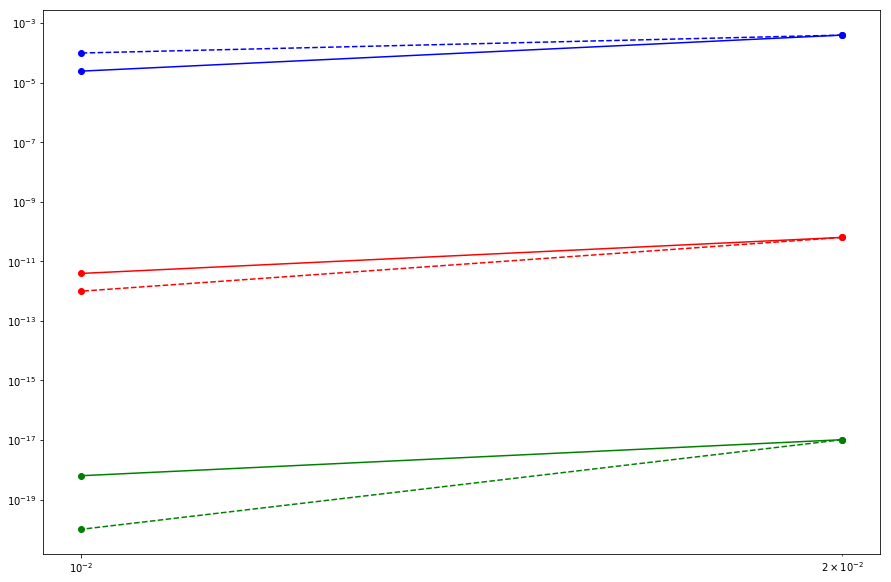

In [19]:
import matplotlib.pyplot as plt
col = ['-ob', '-or', '-og', '-ok', '-oc']
col_2 = ['--ob', '--or', '--og', '--ok', '--oc']
hh = [0.04, 0.02, 0.01, 0.005]
#hh = [1, .5, .25, .125]
#hh = [4*h for h in hh]
plt.figure(figsize=(15, 10))
for j, sso in enumerate(so):
    plt.loglog(hh[1:3], hh[1]**so[j]*error[1:3, j]/error[1, j], col[j])
    plt.loglog(hh[1:3], [h**so[j] for h in hh][1:3], col_2[j])

    #plt.loglog(hh[1:3], error[:, 3])
    #plt.loglog(hh[1:3], [h**so[3] for h in hh])

Text(0.5, 0, 'Space order')

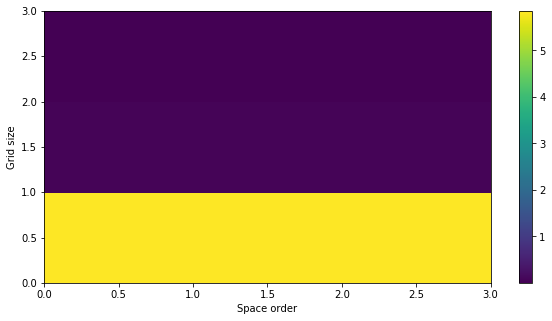

In [20]:
fig = plt.figure(figsize=(10, 5))
im = plt.pcolormesh(error)
fig.colorbar(im)
plt.ylabel('Grid size')
plt.ylabel('Grid size')
plt.ylabel('Grid size')

plt.xlabel('Space order')